In [1]:
import json
from pathlib import Path
from mt.helper import flatten
from datetime import datetime
from dateutil.parser import parse
from typing import Any
import networkx as nx
from torch_geometric.data import Data, Batch
import requests
import re
import torch
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
import pickle
import concurrent.futures
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
if (path:=Path("type_to_int.json")).exists():
    with open(path) as f:
        node_type_to_int = json.load(f)
else:
    response = requests.get("https://raw.githubusercontent.com/tree-sitter/tree-sitter-python/master/src/node-types.json")
    types = re.findall(r'"type": "(.+)"', response.text)
    node_type_to_int =  {"UNK": 0} | {t: i+1 for i, t in enumerate(list(set(types)))}
    with open("type_to_int.json", "w") as f:
        json.dump(node_type_to_int, f)


edge_type_to_int = {
    "child": 0,
    "occurance_of": 1,
    "may_next_use": 2,
}

In [3]:
repo = Path("/home/fox/projects/general/learning-portfolio/university/masters/masters-thesis/data/repos/pytorch/vision")
repo

PosixPath('/home/fox/projects/general/learning-portfolio/university/masters/masters-thesis/data/repos/pytorch/vision')

In [4]:
commit_data_dir = repo / "commit_data"
commit_paths = list(commit_data_dir.glob("*.json"))
commit_paths.sort(key = lambda path: int(path.name.split("_")[0]))
commit_paths = {path.name.split("_")[1].removesuffix(".json"): path for path in commit_paths}

In [5]:
pt_dir = repo / "pts"
pt_dir.mkdir(exist_ok=True)

In [6]:
class GraphDataset(Dataset):
    def __init__(self, root_dir: Path) -> None:
        self.root_dir = root_dir
        with open(self.root_dir / "residuals.pkl", "rb") as f:
            self.targets = pickle.load(f)
        self.files = list(root_dir.glob("*.pt"))
        self.num_samples = len(self.files)

        # self.tgt_mean, self.tgt_std = self.compute_mean_std()

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int) -> tuple[str, Batch, torch.FloatTensor]:
        commit_sha, batch = torch.load(self.root_dir / f"batch_{idx}.pt")
        target = self.targets[commit_sha]
        # target_standardized = (target - self.tgt_mean) / self.tgt_std
        return commit_sha, batch, target
    
    def compute_mean_std(self) -> tuple[float, float]:
        tot_sum, tot_sum_sq, cnt = 0, 0, 0

        for file in self.files:
            _, _, target = torch.load(file)
            tot_sum += target
            tot_sum_sq += (target ** 2)
            cnt += 1
        
        mean = tot_sum / cnt
        var = (tot_sum_sq / cnt) - (mean ** 2)
        std = math.sqrt(var)

        return mean, std

    def inverse_standardize(self, target_standardized: float) -> float:
        return target_standardized * self.tgt_std + self.tgt_mean

In [7]:
# Instantiate the dataset
dataset = GraphDataset(root_dir=pt_dir)

# # Create a DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [8]:
# train_idx, val_idx = train_test_split(range(len(dataset)), test_size=0.2)

# # Create subsets for training and validation
# train_dataset = [dataset[i] for i in train_idx]
# val_dataset = [dataset[i] for i in val_idx]

# # Now create the DataLoaders
# train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [58]:
import torch
from torch_geometric.data import Data, Batch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool, AttentionalAggregation, GATv2Conv

class NodeFeatureEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(NodeFeatureEmbedding, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        
    def forward(self, x):
        # Assuming x is of shape (num_nodes, 1) where each entry is the category index
        return self.embedding(x.squeeze())  # Embedding lookup and squeeze to drop extra dimension
    

class EdgeFeatureEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(EdgeFeatureEmbedding, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        
    def forward(self, edge_attr):
        # Assuming edge_attr is of shape (num_edges, 1) where each entry is the category index
        return self.embedding(edge_attr.squeeze())  # Embedding lookup and squeeze to drop extra dimension


class GATModel(nn.Module):
    def __init__(self, node_embedding_dim, edge_embedding_dim, hidden_channels, out_channels, num_heads=2, dropout_rate=0.2):
        super(GATModel, self).__init__()
        self.conv1 = GATv2Conv(node_embedding_dim, hidden_channels, heads=num_heads, concat=True, edge_dim=edge_embedding_dim)
        self.conv2 = GATv2Conv(hidden_channels * num_heads, hidden_channels, heads=num_heads, concat=True, edge_dim=edge_embedding_dim)
        self.conv3 = GATv2Conv(hidden_channels * num_heads, hidden_channels, heads=1, concat=True, edge_dim=edge_embedding_dim)
        
        self.gate_nn = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1)
        )

        self.attention_aggregation = AttentionalAggregation(gate_nn=self.gate_nn)
        
        self.global_attention_fc = nn.Linear(hidden_channels, 1)
        self.regressor = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_attr, batch):
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = self.conv3(x, edge_index, edge_attr)
        
        x = self.attention_aggregation(x, index=batch)
        
        global_attention_scores = self.global_attention_fc(x).squeeze(-1)
        global_attention_weights = F.softmax(global_attention_scores, dim=0)
        
        x = torch.sum(x * global_attention_weights.unsqueeze(-1), dim=0)

        return self.regressor(x)

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [60]:
node_embedding_dim = 64
edge_embedding_dim = 3
num_node_features = len(node_type_to_int)
num_edge_features = len(edge_type_to_int)

node_embedding_module = NodeFeatureEmbedding(num_embeddings=num_node_features, embedding_dim=node_embedding_dim)
edge_embedding_module = EdgeFeatureEmbedding(num_embeddings=num_edge_features, embedding_dim=edge_embedding_dim)
model = GATModel(node_embedding_dim=node_embedding_dim, edge_embedding_dim=edge_embedding_dim, hidden_channels=8, out_channels=1)
model.to(device)
edge_embedding_module.to(device)
node_embedding_module.to(device)

NodeFeatureEmbedding(
  (embedding): Embedding(216, 64)
)

In [61]:
from torch_geometric.nn import summary

In [62]:
model.eval()
node_embedding_module.eval()
edge_embedding_module.eval()
total_loss = 0
with torch.no_grad():
    for commit_sha, graph_batch, target in dataloader:
        # Transfer data to the device
        x = graph_batch.x.to(device)
        edge_index = graph_batch.edge_index.to(device)
        edge_attr = graph_batch.edge_attr.to(device)
        batch = graph_batch.batch.to(device)
        target = target.to(device)
        
        # Embedding step
        embedded_edge_attr = edge_embedding_module(edge_attr)
        embedded_x = node_embedding_module(x)

        print(summary(model, embedded_x, edge_index, embedded_edge_attr, batch))
        output = model(embedded_x, edge_index, embedded_edge_attr, batch)
        # make_dot(output, params=dict(list(model.named_parameters()))).render("model_architecture", format="png")
        break

+-------------------------------------------------+----------------------------------------------+----------------+----------+
| Layer                                           | Input Shape                                  | Output Shape   | #Param   |
|-------------------------------------------------+----------------------------------------------+----------------+----------|
| GATModel                                        | [31958, 64], [2, 49361], [49361, 3], [31958] | [1]            | 3,195    |
| ├─(conv1)GATv2Conv                              | [31958, 64], [2, 49361], [49361, 3]          | [31958, 16]    | 2,160    |
| ├─(conv2)GATv2Conv                              | [31958, 16], [2, 49361], [49361, 3]          | [31958, 16]    | 624      |
| ├─(conv3)GATv2Conv                              | [31958, 16], [2, 49361], [49361, 3]          | [31958, 8]     | 312      |
| ├─(gate_nn)Sequential                           | [31958, 8]                                   | [31958, 1]  

In [63]:
def train_one_epoch(dataloader, criterion, optimizer, device) -> float:
    model.train()
    node_embedding_module.train()
    edge_embedding_module.train()
    total_loss = 0
    for commit_sha, graph_batch, target in dataloader:
        # Transfer data to the device
        x = graph_batch.x.to(device)
        edge_index = graph_batch.edge_index.to(device)
        edge_attr = graph_batch.edge_attr.to(device)
        batch = graph_batch.batch.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        
        # Embedding step
        embedded_edge_attr = edge_embedding_module(edge_attr)
        embedded_x = node_embedding_module(x)
        
        # Model prediction
        prediction = model(embedded_x, edge_index, embedded_edge_attr, batch)
        loss = criterion(prediction, target)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    epoch_loss = total_loss / len(dataloader)
    return epoch_loss

In [64]:
def validate_one_epoch(dataloader, criterion, device) -> float:
    model.eval()
    node_embedding_module.eval()
    edge_embedding_module.eval()
    total_loss = 0
    with torch.no_grad():
        for commit_sha, graph_batch, target in dataloader:
            # Transfer data to the device
            x = graph_batch.x.to(device)
            edge_index = graph_batch.edge_index.to(device)
            edge_attr = graph_batch.edge_attr.to(device)
            batch = graph_batch.batch.to(device)
            target = target.to(device)
            
            # Embedding step
            embedded_edge_attr = edge_embedding_module(edge_attr)
            embedded_x = node_embedding_module(x)
            
            # Model prediction
            prediction = model(embedded_x, edge_index, embedded_edge_attr, batch)
            loss = criterion(prediction, target)
            
            total_loss += loss.item()

    epoch_loss = total_loss / len(dataloader)
    return epoch_loss

In [57]:
weight_path = Path("best_weights_glob_attn_v6.pth")
best_loss = float('inf')  # Initialize best_loss to infinity
best_model_state = None   # To store the state of the best model

optimizer = torch.optim.Adam(
    list(edge_embedding_module.parameters())
    + list(node_embedding_module.parameters())
    + list(model.parameters()),
    lr=0.01,
    weight_decay=1e-4
)
criterion = nn.MSELoss()

for train_loop in range(5):
    print(f"{datetime.now()}: Training loop {train_loop + 1}")
    for param_group in optimizer.param_groups:
        param_group["lr"] *= 0.1

    if weight_path.exists():
        weights = torch.load(weight_path)
        node_emb_weights, edge_emb_weights, model_weights = (
            weights["node_embedding_module_state_dict"],
            weights["edge_embedding_module_state_dict"],
            weights["model_state_dict"],
        )
        node_embedding_module.load_state_dict(node_emb_weights)
        edge_embedding_module.load_state_dict(edge_emb_weights)
        model.load_state_dict(model_weights)

    for epoch in range(20):  # For example, 10 epochs
        train_loss = train_one_epoch(dataloader, criterion, optimizer, device)
        # val_loss = validate_one_epoch(val_dataloader, criterion, device)
        print(f"{datetime.now()}: Epoch {epoch+1}: Training Loss = {train_loss}")

        if train_loss < best_loss:
            best_loss = train_loss
            # Save the model state
            best_model_state = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "node_embedding_module_state_dict": node_embedding_module.state_dict(),
                "edge_embedding_module_state_dict": edge_embedding_module.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": best_loss,
            }
            # Example saving to file, adjust the path as necessary
            torch.save(best_model_state, weight_path)

    print(f"{datetime.now()}: Best Loss: {best_loss}")

2024-05-14 12:31:50.559019: Training loop 1
2024-05-14 12:34:29.908528: Epoch 1: Training Loss = 962.1141471651014
2024-05-14 12:37:08.390913: Epoch 2: Training Loss = 752.8585271526865
2024-05-14 12:39:46.544442: Epoch 3: Training Loss = 629.4945306548004
2024-05-14 12:42:26.482957: Epoch 4: Training Loss = 502.59883396420304
2024-05-14 12:45:08.036980: Epoch 5: Training Loss = 441.32642862807506
2024-05-14 12:47:48.966018: Epoch 6: Training Loss = 396.97634253990805
2024-05-14 12:50:28.727770: Epoch 7: Training Loss = 371.0677669785205
2024-05-14 12:53:08.110692: Epoch 8: Training Loss = 288.9149341590262
2024-05-14 12:55:47.942243: Epoch 9: Training Loss = 251.3169058232052
2024-05-14 12:58:27.028844: Epoch 10: Training Loss = 230.80199621525236
2024-05-14 13:01:07.424359: Epoch 11: Training Loss = 233.42506978256236
2024-05-14 13:03:48.179870: Epoch 12: Training Loss = 230.90166508703297
2024-05-14 13:06:32.507858: Epoch 13: Training Loss = 220.80532670233754
2024-05-14 13:09:16.26

KeyboardInterrupt: 

In [65]:
weight_path = Path("best_weights_glob_attn_v6.pth")

In [66]:
weights = torch.load(weight_path)
node_emb_weights, edge_emb_weights, model_weights = (
    weights["node_embedding_module_state_dict"],
    weights["edge_embedding_module_state_dict"],
    weights["model_state_dict"],
)
node_embedding_module.load_state_dict(node_emb_weights)
edge_embedding_module.load_state_dict(edge_emb_weights)
model.load_state_dict(model_weights)

<All keys matched successfully>

In [67]:
model.to(device)
node_embedding_module.to(device)
edge_embedding_module.to(device)

model.eval()
node_embedding_module.eval()
edge_embedding_module.eval()

EdgeFeatureEmbedding(
  (embedding): Embedding(3, 3)
)

In [68]:
targets = []
predictions = []

for commit_sha, graph_batch, target in dataloader:
    # Transfer data to the device
    x = graph_batch.x.to(device)
    edge_index = graph_batch.edge_index.to(device)
    edge_attr = graph_batch.edge_attr.to(device)
    batch = graph_batch.batch.to(device)
    target = target.to(device)
    
    # Embedding step
    embedded_edge_attr = edge_embedding_module(edge_attr)
    embedded_x = node_embedding_module(x)
    
    # Model prediction
    prediction = model(embedded_x, edge_index, embedded_edge_attr, batch)
    targets.append(target.detach().cpu())
    predictions.append(prediction.detach().cpu())
    # loss = criterion(prediction, target)
    
    # loss.backward()
    # optimizer.step()
    
    # total_loss += loss.item()

predictions = torch.cat(predictions).numpy()
targets = torch.cat(targets).numpy()

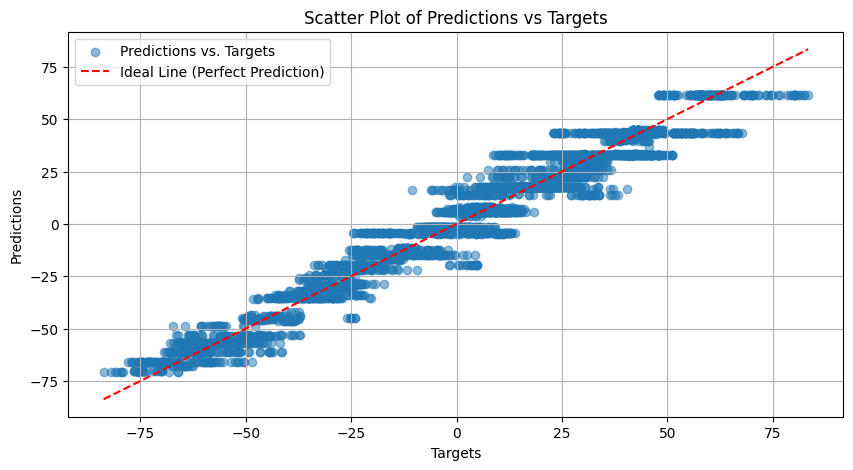

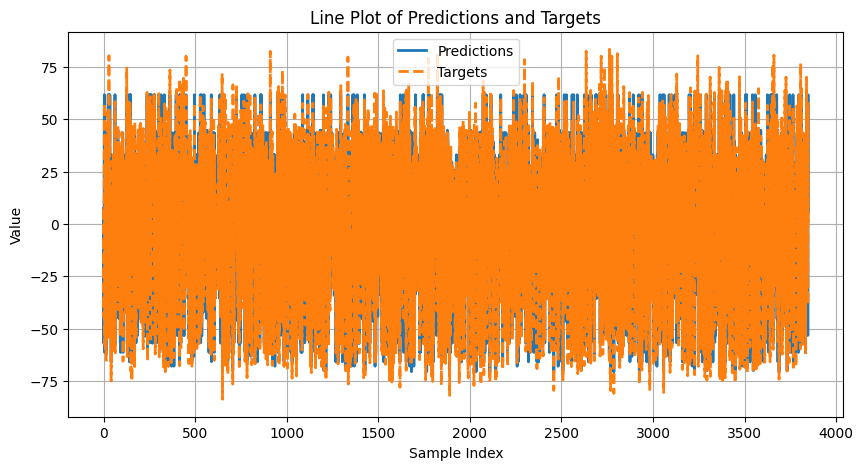

In [69]:
# Scatter plot of predictions vs. targets
plt.figure(figsize=(10, 5))
plt.scatter(targets, predictions, alpha=0.5, label='Predictions vs. Targets')
plt.title('Scatter Plot of Predictions vs Targets')

# Ideal line (x = y line)
ideal_line_range = np.linspace(min(targets.min(), predictions.min()), 
                               max(targets.max(), predictions.max()), 
                               num=100)
plt.plot(ideal_line_range, ideal_line_range, 'r--', label='Ideal Line (Perfect Prediction)')

plt.xlabel('Targets')
plt.ylabel('Predictions')
plt.legend()
plt.grid(True)
plt.show()

# Line plot of predictions and targets
plt.figure(figsize=(10, 5))
plt.plot(predictions, label='Predictions', linewidth=2)
plt.plot(targets, label='Targets', linewidth=2, linestyle='--')
plt.title('Line Plot of Predictions and Targets')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
from torch_geometric.explain import CaptumExplainer, Explainer, AttentionExplainer, DummyExplainer, GNNExplainer, GraphMaskExplainer


gnn_explainer = GNNExplainer().to(device)
explainer = Explainer(
    model=model,
    algorithm=gnn_explainer,
    explanation_type='model',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    ),
    node_mask_type='object',
    edge_mask_type='object',
)

In [ ]:
from random import randint

# Choosing a random point for the visualization
point = dataset[randint(0, len(dataset))]